## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [6]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

df = pd.read_csv("diabetes.csv")  # Import dataset
df.head()                         # Inital Reading 

predictors = ["Glucose", "BMI", "BloodPressure"] # Predictors
X = df[predictors].values
y = df["Outcome"].values  # 0/1

X = np.column_stack([np.ones(len(X)), X]) # Add Column of 1's 

In [19]:
with pm.Model() as GLM:
    
    p = X.shape[1] # Number of columns in X (including intercept)
    
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p) # Prior on Beta
    
    invlink = pm.math.sigmoid(X@betas) # inverse link
    
    model = pm.Bernoulli('model', p=invlink, observed=y) # Bernoulli likelihood
    
with GLM:
    idata = pm.sample(
        draws=3000,
        tune=3000,
        chains=4,         # Usually 4 chains is good
        target_accept=0.95,
        random_seed=42
    )

/opt/conda/lib/python3.11/site-packages/pymc/model/core.py:560: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 6000 divergences after tuning. Increase `target_accept` or reparameterize.


/opt/conda/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.143,0.132,0.011,0.308,0.066,0.012,5.0,116.0,3.41
betas[1],0.049,0.507,-0.612,0.813,0.253,0.128,4.0,4.0,3.41
betas[2],-0.163,0.460,-0.919,0.326,0.230,0.123,4.0,4.0,3.41


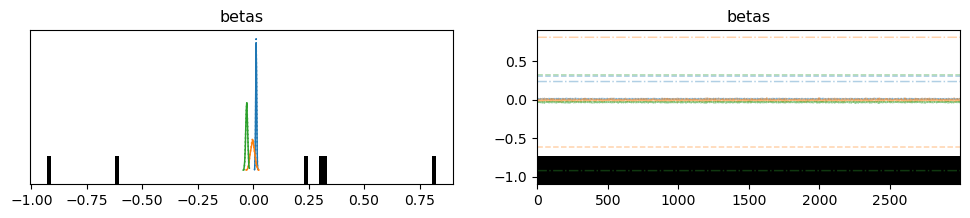

In [20]:
az.summary(idata, var_names=['betas'])      # Posterior summaries
az.plot_trace(idata, var_names=['betas'])   # Trace + distribution plots
az.summary(idata)

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# -----------------------------------------------------------
# 1. Load and Prepare Data
# -----------------------------------------------------------
df = pd.read_csv("Life Expectancy Data.csv")
# Drop missing rows in columns of interest
df = df.dropna(subset=[
    "percentage expenditure", " BMI ", "Schooling", "Population",
    "Life expectancy ", "Adult Mortality", "infant deaths"
])

# Define predictor and outcome columns
predictors = ["percentage expenditure", " BMI ", "Schooling", "Population"]
outcomes   = ["Life expectancy ", "Adult Mortality", "infant deaths"]

# Convert to NumPy arrays
X_full = df[predictors].values
y_full = df[outcomes].values

# The full dataset size
n_full = X_full.shape[0]

# -----------------------------------------------------------
# 2. Choose Three n-values: small, medium, and full
# -----------------------------------------------------------
# For example, let's say small ~ 100 rows, medium ~ 300 rows, and full
n_values = [100, 300, n_full]

# We'll store the InferenceData objects in a dictionary for easy reference
idata_dict = {}

# -----------------------------------------------------------
# 3. Loop Over Each n and Run the Model
# -----------------------------------------------------------
for n in n_values:
    # Truncate or sample the dataset to n rows
    # Here, we sample for variety; you could also do df.head(n) if you prefer
    df_trunc = df.sample(n=n, random_state=42)

    # Prepare arrays for this subset
    X_data = df_trunc[predictors].values
    y_data = df_trunc[outcomes].values

    # Get shapes
    n_rows, p = X_data.shape
    m = 3

    print(f"\n--- Fitting model for n={n_rows} (p={p}, m={m}) ---")

    with pm.Model() as multivariate_model:
        # 1) LKJ Cholesky prior for covariance
        packed_L = pm.LKJCholeskyCov(
            "packed_L",
            n=m,
            eta=2.0,
            sd_dist=pm.Exponential.dist(1.0, shape=m),
            compute_corr=False
        )
        L = pm.expand_packed_triangular(m, packed_L)
        
        # 2) Regression coefficients: shape (p, m)
        betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
        
        # 3) Mean structure
        mu = pm.math.dot(X_data, betas)
        
        # 4) Multivariate Normal likelihood
        y_obs = pm.MvNormal("y_obs", mu=mu, chol=L, observed=y_data)
        
        # 5) Sample
        idata2 = pm.sample()
    
    # Store the results
    idata_dict[f"n={n_rows}"] = idata

    # Basic summary
    summary_betas = az.summary(idata, var_names=["betas"])
    az.plot_trace(idata2, var_names=['betas'])


--- Fitting model for n=100 (p=4, m=3) ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3479 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.



--- Fitting model for n=300 (p=4, m=3) ---


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [packed_L, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
